# **Digital Signal and Image Management - 1D Signal Processing**<br/>

---

#Human Activity Recognition using Smartphone Accelerometer Data

Authors:

Luca Galli - 905236 | Davide Ronchi - 903320

---



# Contents
In this Demo notebook we will load a *.csv* file containing accelerometers signals recorded using *Physics toolbox* app. We will preprocess the signal and feed it into different models to evaluate the perfomance, trying to predict the recorded activity.

We will evaluate the following models
* **SVM_MFCC**
* **LSTM1**
* **LSTM3**
* **LSTM3**


# Importing Libraries

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
import scipy
from scipy.io import arff
from io import StringIO
import seaborn as sns
from tqdm import tqdm
import pickle
import joblib
from librosa.feature import melspectrogram, mfcc
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

import tensorflow as tf
from tensorflow import keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Define functions to prepare the signal

In [3]:
def data_prep(data, activity, user, rec_n):
  for column in ['time', 'gFx', 'gFy', 'gFz', 'TgF']:
    try:
      # Replace commas with dots and convert to float
      data[column] = data[column].astype('str').str.replace(',', '.').astype(float)
    except ValueError as e:
      print(f"Error converting {column} to float: {e}")
      # Print unique values in the column for further investigation
      print(f"Unique values in {column}: {data[column].unique()}")

  # Append the 'user' and the 'activity' columns
  data['user'] = user
  data['activity'] = activity
  data['rec_n'] = rec_n

  # Remove first and last 5 seconds
  data = data[(data['time'] >= 5) & (data['time']<= data['time'].max()-5)]

  return data

In [4]:
def file_name_info(file_name):
  match = re.search(r'^(?P<activity>[a-zA-Z]+)_(?P<user>\d{2})_(?P<rec_n>\d{2})(\.csv)?$', file_name)

  if match:
    # Use match.groupdict() to directly get a dictionary of named groups
    info_dict = match.groupdict()
    return info_dict.get('activity'), info_dict.get('user'), info_dict.get('rec_n')
  else:
    # Handle the case when there's no match
    return None, None, None

# Loading the signal

Setting the folder path

In [5]:
folder = '/content/drive/MyDrive/DSaIM_project/1D/Materials/Demo_recordings/'

List all files in the folder

In [6]:
files_list = sorted(os.listdir(folder))
files_list

['upstairs_02_01.csv']

Printing the full path of the csv files in the folder

In [7]:
full_paths = [os.path.join(folder, file) for file in files_list]
full_paths

['/content/drive/MyDrive/DSaIM_project/1D/Materials/Demo_recordings/upstairs_02_01.csv']

In [8]:
#'/content/drive/MyDrive/DSaIM_project/1D/Materials/Demo_recordings/upstairs_02_01.csv'

Selecting the last uploaded file

In [9]:
last_uploaded_file = max(full_paths, key=os.path.getmtime)
last_uploaded_file

'/content/drive/MyDrive/DSaIM_project/1D/Materials/Demo_recordings/upstairs_02_01.csv'

In [10]:
file_name = os.path.basename(last_uploaded_file)
file_name

'upstairs_02_01.csv'

Reading the .csv file

In [11]:
signal = pd.read_csv(folder + file_name, sep = ";", header=0)
signal.head()

,time,gFx,gFy,gFz,TgF
0,"0,000995","0,3244","0,5311","0,8507","1,054"
1,"0,001219","0,3369","0,5294","0,8614","1,066"
2,"0,002053","0,3415","0,5297","0,8666","1,071"
3,"0,004016","0,3516","0,5292","0,8753","1,082"
4,"0,006291","0,3579","0,5287","0,8827","1,089"


# Preparing the signal

In [12]:
activity, user, rec_n = file_name_info(file_name) # Extract activity, user name, and recording number
signal = data_prep(signal, activity=activity, user=user, rec_n = rec_n) # Preprocess the signal
signal = signal.astype({"user": int, "rec_n": int}) # Convert user and recording number to integers
signal = signal.drop('TgF', axis=1) # Remove TgF column
signal.loc[:, ['gFx', 'gFy', 'gFz']] *= 9.81 # Convert gFx, gFy, gFz to m/s^2
# signal.head()

In [13]:
activity, user, rec_n

('upstairs', '02', '01')

In [14]:
sampling_rate = 20 # Sampling rate in Hz

Resampling the signal to get a uniform sampling rate

In [15]:
# Drop duplicates
signal = signal.drop_duplicates(subset='time')

start_time = signal['time'].iloc[0]
stop_time = signal['time'].iloc[-1]

# crea l'asse x (time) uniforme
Tx = np.arange(start_time, stop_time, 1/(sampling_rate))

# crea la spline del segnale corrente per gFx
cs_x = scipy.interpolate.CubicSpline(signal['time'], signal['gFx'])

# crea la spline del segnale corrente per gFy
cs_y = scipy.interpolate.CubicSpline(signal['time'], signal['gFy'])

# crea la spline del segnale corrente per gFz
cs_z = scipy.interpolate.CubicSpline(signal['time'], signal['gFz'])

resampled_ax = cs_x(Tx)
resampled_ay = cs_y(Tx)
resampled_az = cs_z(Tx)

clean_signal = pd.DataFrame({'time': Tx, 'ax': resampled_ax, 'ay': resampled_ay, 'az': resampled_az})
clean_signal['user'] = user
clean_signal['activity'] = activity
clean_signal['rec_n'] = rec_n

In [16]:
clean_signal.head()

,time,ax,ay,az,user,activity,rec_n
0,5.003822,-0.599391,-7.820532,1.662795,02,upstairs,01
1,5.053822,-1.689780,-8.101119,0.771692,02,upstairs,01
2,5.103822,-2.540546,-5.400583,1.571372,02,upstairs,01
3,5.153822,1.904520,-22.611869,2.916273,02,upstairs,01
4,5.203822,0.523307,-8.633478,0.958914,02,upstairs,01


We change the sign to the y-axis to be coherent with the convention in the dataset

In [17]:
clean_signal['ay'] = -clean_signal['ay'].astype(float)

In [18]:
clean_signal.head()

,time,ax,ay,az,user,activity,rec_n
0,5.003822,-0.599391,7.820532,1.662795,02,upstairs,01
1,5.053822,-1.689780,8.101119,0.771692,02,upstairs,01
2,5.103822,-2.540546,5.400583,1.571372,02,upstairs,01
3,5.153822,1.904520,22.611869,2.916273,02,upstairs,01
4,5.203822,0.523307,8.633478,0.958914,02,upstairs,01


# Plotting the signal

Plotting the sinals separately

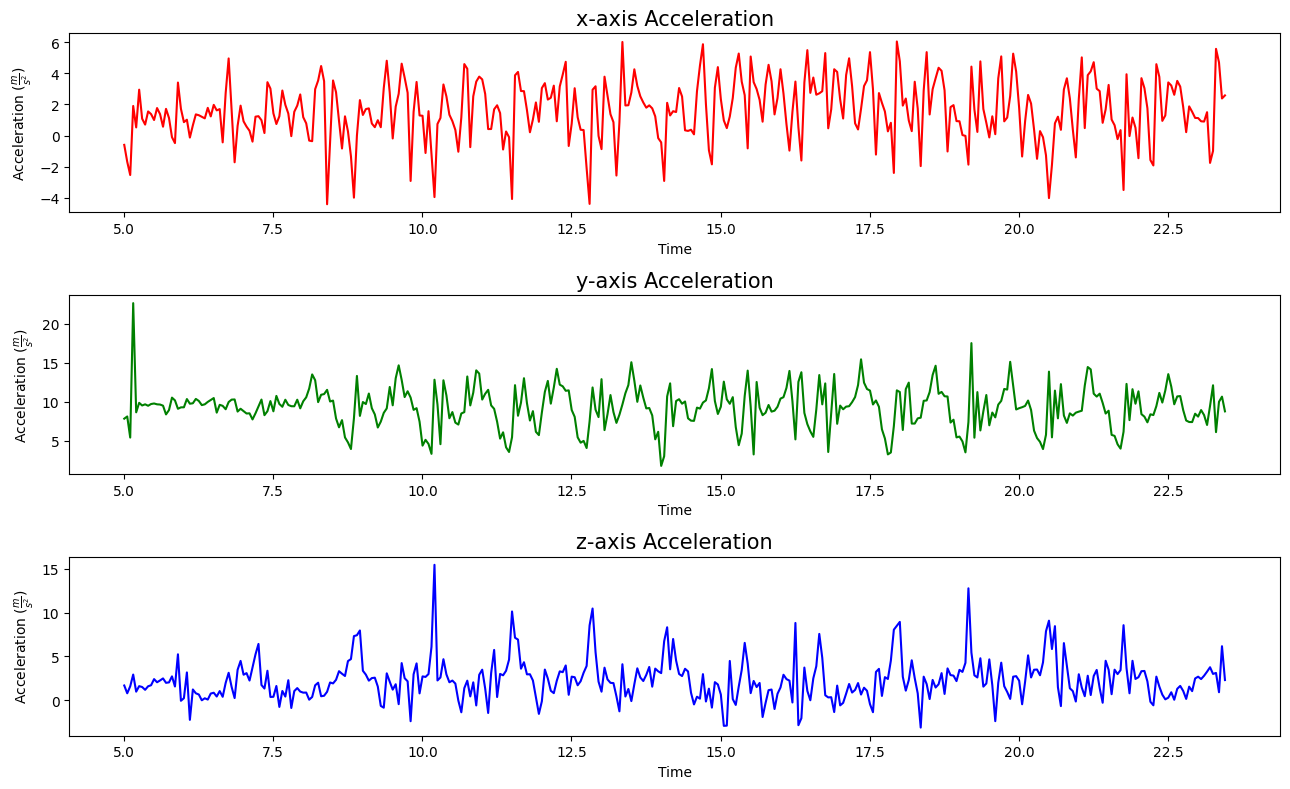

In [19]:
fig, ax = plt.subplots(3,1, figsize=(13,8))

label_fontsize = 10

ax[0].plot(clean_signal['time'], clean_signal['ax'], 'r')
ax[0].set_title("x-axis Acceleration", fontsize=label_fontsize+5)
ax[0].set_xlabel('Time', fontsize=label_fontsize)
ax[0].set_ylabel('Acceleration ($\\frac{m}{s^2}$)', fontsize=label_fontsize)

ax[1].plot(clean_signal['time'], clean_signal['ay'], 'g')
ax[1].set_title("y-axis Acceleration", fontsize=label_fontsize+5)
ax[1].set_xlabel('Time', fontsize=label_fontsize)
ax[1].set_ylabel('Acceleration ($\\frac{m}{s^2}$)', fontsize=label_fontsize)

ax[2].plot(clean_signal['time'], clean_signal['az'], 'b')
ax[2].set_title("z-axis Acceleration", fontsize=label_fontsize+5)
ax[2].set_xlabel('Time', fontsize=label_fontsize)
ax[2].set_ylabel('Acceleration ($\\frac{m}{s^2}$)', fontsize=label_fontsize)

plt.tight_layout()
plt.show()

Plotting the signals together

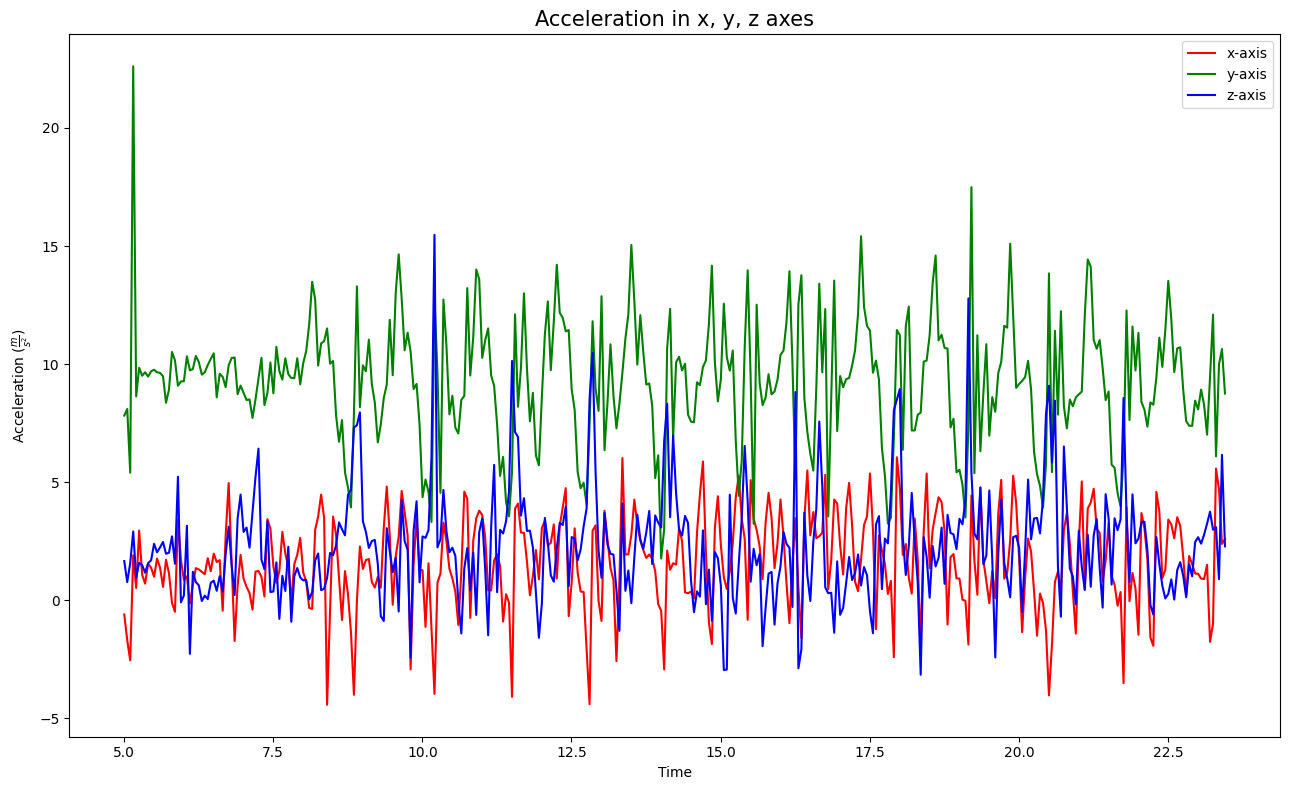

In [20]:
fig, ax = plt.subplots(figsize=(13, 8))

label_fontsize = 10

# Plotting x, y, z axes on the same plot
ax.plot(clean_signal['time'], clean_signal['ax'], 'r', label='x-axis')
ax.plot(clean_signal['time'], clean_signal['ay'], 'g', label='y-axis')
ax.plot(clean_signal['time'], clean_signal['az'], 'b', label='z-axis')

# Setting title and labels
ax.set_title("Acceleration in x, y, z axes", fontsize=label_fontsize + 5)
ax.set_xlabel('Time', fontsize=label_fontsize)
ax.set_ylabel('Acceleration ($\\frac{m}{s^2}$)', fontsize=label_fontsize)

# Adding legend
ax.legend()

plt.tight_layout()
plt.show()


# SVM_MFCC

In [21]:
activities = ['walking', 'jogging', 'sitting', 'standing', 'upstairs', 'downstairs']

In [22]:
base_path = '/content/drive/MyDrive/DSaIM_project/1D/'

Defining the function to extract MFCC features

In [23]:
def feats_mfcc(input, rate=sampling_rate, flatten=True):
    mfccs = mfcc(y=input*1.0, sr=rate, n_fft=64, hop_length=32, n_mfcc=13, n_mels=10)
    if flatten:
        output = mfccs.flatten()
    else:
        output = mfccs
    return output

Loading the trained model

In [24]:
models_filepath = base_path + 'Models/'
os.makedirs(models_filepath, exist_ok=True)

SVM_MFCC_filepath = os.path.join(models_filepath, 'SVM_MFCC_model.pkl')
with open(SVM_MFCC_filepath, 'rb') as f:
    SVM_MFCC = pickle.load(f)

Taking a portion of the signal of length `signal_length = 5` seconds in the center of the signal

In [25]:
sampling_rate = 20
signal_length = 5

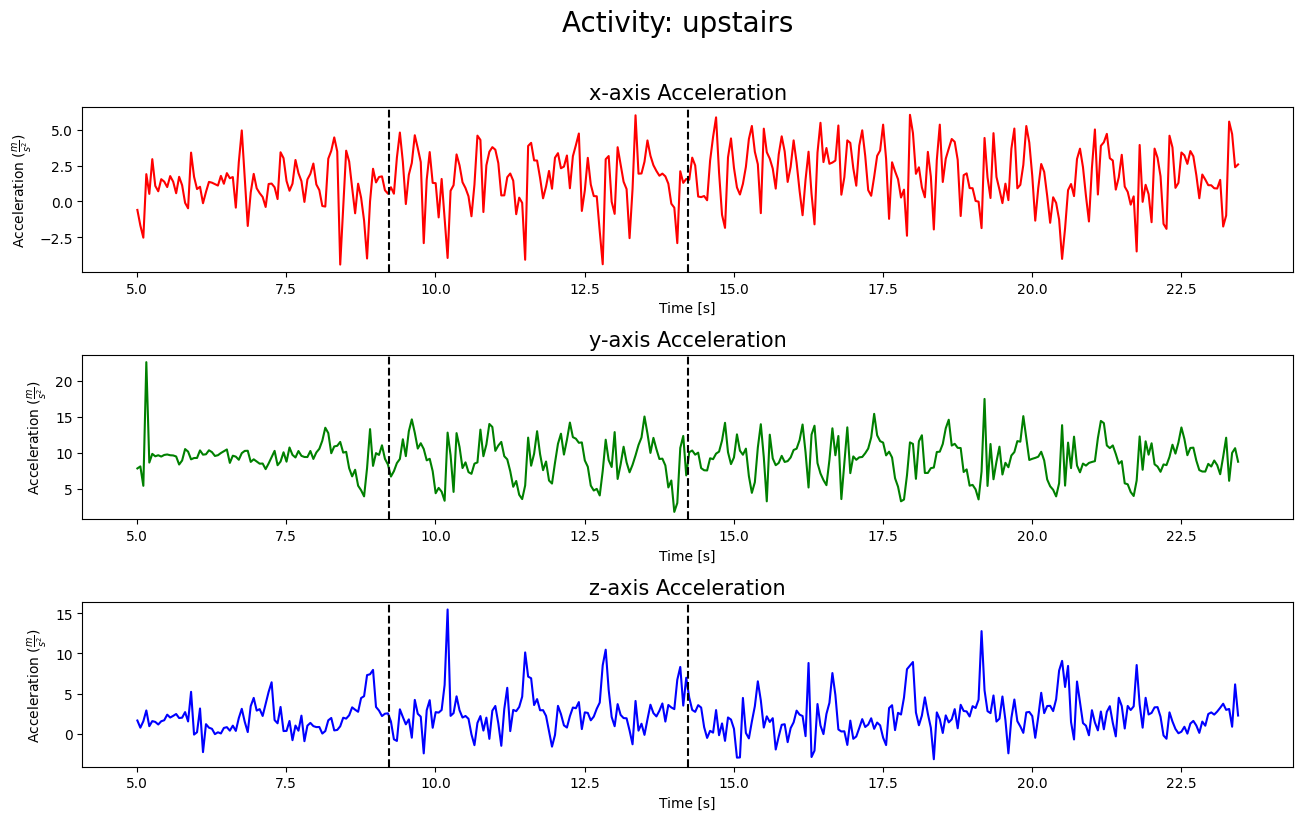

In [26]:
fig, ax = plt.subplots(3,1, figsize=(13,8))

label_fontsize = 10

ax[0].plot(clean_signal['time'], clean_signal['ax'], 'r')
ax[0].set_title("x-axis Acceleration", fontsize=label_fontsize+5)
ax[0].set_xlabel('Time [s]', fontsize=label_fontsize)
ax[0].set_ylabel('Acceleration ($\\frac{m}{s^2}$)', fontsize=label_fontsize)
ax[0].axvline(x=max(clean_signal['time'])/2 - signal_length/2, color='k', linestyle='--')
ax[0].axvline(x=max(clean_signal['time'])/2 + signal_length/2, color='k', linestyle='--')

ax[1].plot(clean_signal['time'], clean_signal['ay'], 'g')
ax[1].set_title("y-axis Acceleration", fontsize=label_fontsize+5)
ax[1].set_xlabel('Time [s]', fontsize=label_fontsize)
ax[1].set_ylabel('Acceleration ($\\frac{m}{s^2}$)', fontsize=label_fontsize)
ax[1].axvline(x=max(clean_signal['time'])/2 - signal_length/2, color='k', linestyle='--')
ax[1].axvline(x=max(clean_signal['time'])/2 + signal_length/2, color='k', linestyle='--')

ax[2].plot(clean_signal['time'], clean_signal['az'], 'b')
ax[2].set_title("z-axis Acceleration", fontsize=label_fontsize+5)
ax[2].set_xlabel('Time [s]', fontsize=label_fontsize)
ax[2].set_ylabel('Acceleration ($\\frac{m}{s^2}$)', fontsize=label_fontsize)
ax[2].axvline(x=max(clean_signal['time'])/2 - signal_length/2, color='k', linestyle='--')
ax[2].axvline(x=max(clean_signal['time'])/2 + signal_length/2, color='k', linestyle='--')

plt.suptitle(f'Activity: {activity}', fontsize= 20, x=0.515, y=1.02, ha='center')
plt.tight_layout()
plt.show()

Extracting the 5 seconds signal

In [27]:
axs = np.array(clean_signal['ax'][int(len(clean_signal)/2) - int(signal_length*sampling_rate/2) : int(len(clean_signal)/2) + int(signal_length*sampling_rate/2)])
ays = np.array(clean_signal['ay'][int(len(clean_signal)/2) - int(signal_length*sampling_rate/2) : int(len(clean_signal)/2) + int(signal_length*sampling_rate/2)])
azs = np.array(clean_signal['az'][int(len(clean_signal)/2) - int(signal_length*sampling_rate/2) : int(len(clean_signal)/2) + int(signal_length*sampling_rate/2)])

In [28]:
print(f"X_train shape: \t{axs.shape},\t\tmin value: {axs.min():.3f}, \tmax value: {axs.max():.3f}")
print(f"X_train shape: \t{ays.shape},\t\tmin value: {ays.min():.3f}, \tmax value: {ays.max():.3f}")
print(f"X_train shape: \t{azs.shape},\t\tmin value: {azs.min():.3f}, \tmax value: {azs.max():.3f}")

X_train shape: 	(100,),		min value: -4.401, 	max value: 6.024
X_train shape: 	(100,),		min value: 1.770, 	max value: 15.045
X_train shape: 	(100,),		min value: -2.954, 	max value: 10.472


Plotting the extracted segment of signal

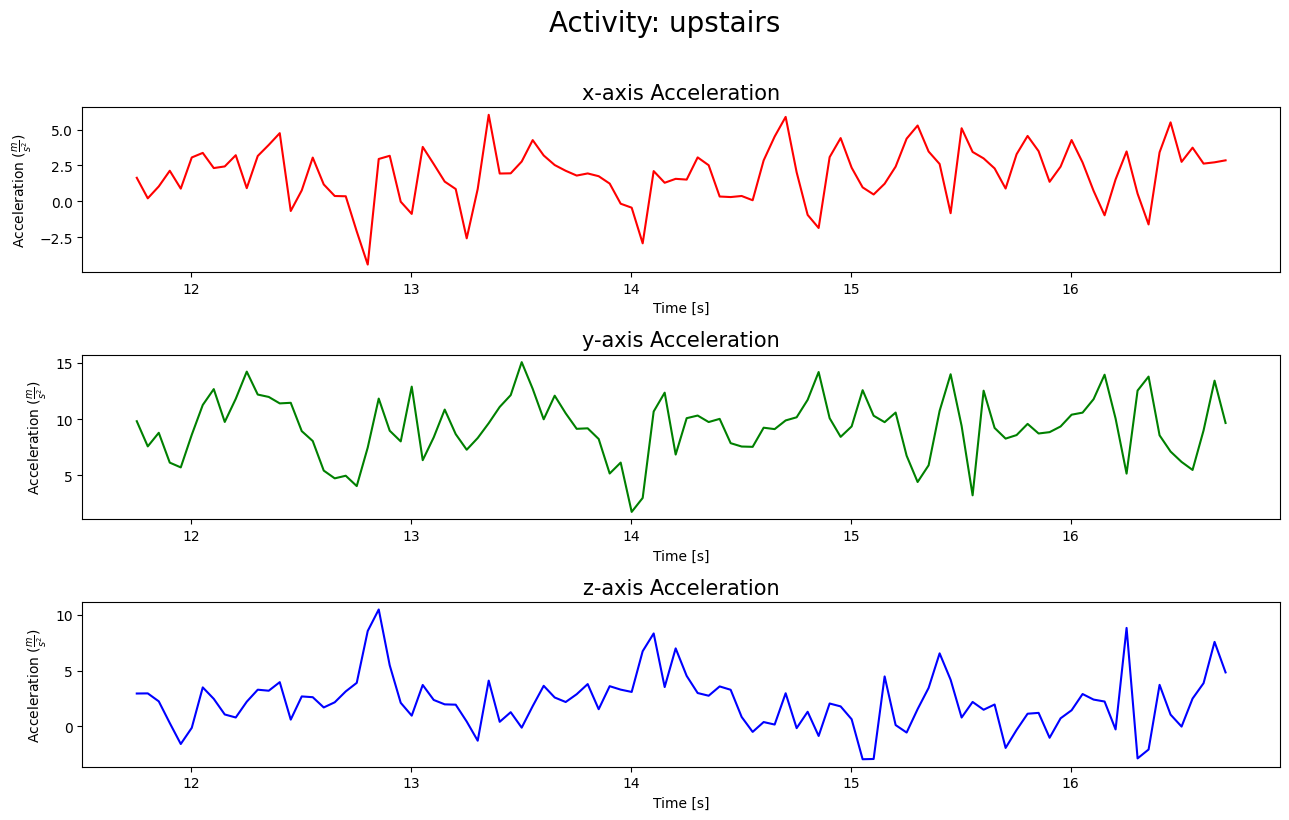

In [29]:
fig, ax = plt.subplots(3,1, figsize=(13,8))

label_fontsize = 10

ax[0].plot(clean_signal['time'][int(len(clean_signal)/2) - int(signal_length*sampling_rate/2) : int(len(clean_signal)/2) + int(signal_length*sampling_rate/2)], axs, 'r')
ax[0].set_title("x-axis Acceleration", fontsize=label_fontsize+5)
ax[0].set_xlabel('Time [s]', fontsize=label_fontsize)
ax[0].set_ylabel('Acceleration ($\\frac{m}{s^2}$)', fontsize=label_fontsize)

ax[1].plot(clean_signal['time'][int(len(clean_signal)/2) - int(signal_length*sampling_rate/2) : int(len(clean_signal)/2) + int(signal_length*sampling_rate/2)], ays, 'g')
ax[1].set_title("y-axis Acceleration", fontsize=label_fontsize+5)
ax[1].set_xlabel('Time [s]', fontsize=label_fontsize)
ax[1].set_ylabel('Acceleration ($\\frac{m}{s^2}$)', fontsize=label_fontsize)

ax[2].plot(clean_signal['time'][int(len(clean_signal)/2) - int(signal_length*sampling_rate/2) : int(len(clean_signal)/2) + int(signal_length*sampling_rate/2)], azs, 'b')
ax[2].set_title("z-axis Acceleration", fontsize=label_fontsize+5)
ax[2].set_xlabel('Time [s]', fontsize=label_fontsize)
ax[2].set_ylabel('Acceleration ($\\frac{m}{s^2}$)', fontsize=label_fontsize)

plt.suptitle(f'Activity: {activity}', fontsize= 20, x=0.515, y=1.02, ha='center')
plt.tight_layout()
plt.show()

In [30]:
#apply feature_extractor to each of them
features_x = feats_mfcc(axs)
features_y = feats_mfcc(ays)
features_z = feats_mfcc(azs)

Putting together the three axis

In [31]:
features = []
labels = []

features.append([features_x, features_y, features_z])
labels.append(activity)
features = np.asarray(features)
labels = np.asarray(labels)

In [32]:
features.shape

(1, 3, 40)

Loading the mean and the standard deviation of the training data and standardize the signal

In [33]:
with open(base_path + 'training_data/SVM_MFCC/X_train_mean.pkl', 'rb') as f:
    X_train_mean = pickle.load(f)

with open(base_path + 'training_data/SVM_MFCC/X_train_std.pkl', 'rb') as f:
    X_train_std = pickle.load(f)

In [34]:
features[0] = (features[0] - np.array(X_train_mean)[:, None]) / np.array(X_train_std)[:, None]

In [35]:
features = features.reshape((1, -1))

Predict the activity

In [36]:
predictions = SVM_MFCC.predict(features)

In [37]:
print(f'Ground Truth: {activity} \nPrediction: {predictions[0]}')

Ground Truth: upstairs 
Prediction: upstairs


# LSTM1

In [38]:
activities = ['walking', 'jogging', 'sitting', 'standing', 'upstairs', 'downstairs']

Loading the model

In [39]:
base_path = '/content/drive/MyDrive/DSaIM_project/1D/'

In [40]:
LSTM1_checkpoint_filepath = base_path + 'Models/LSTM1_checkpoint.keras'
LSTM1 = keras.models.load_model(LSTM1_checkpoint_filepath)

Taking a portion of the signal of length `signal_length = 5` seconds in the center of the signal

In [41]:
sampling_rate = 20
signal_length = 5

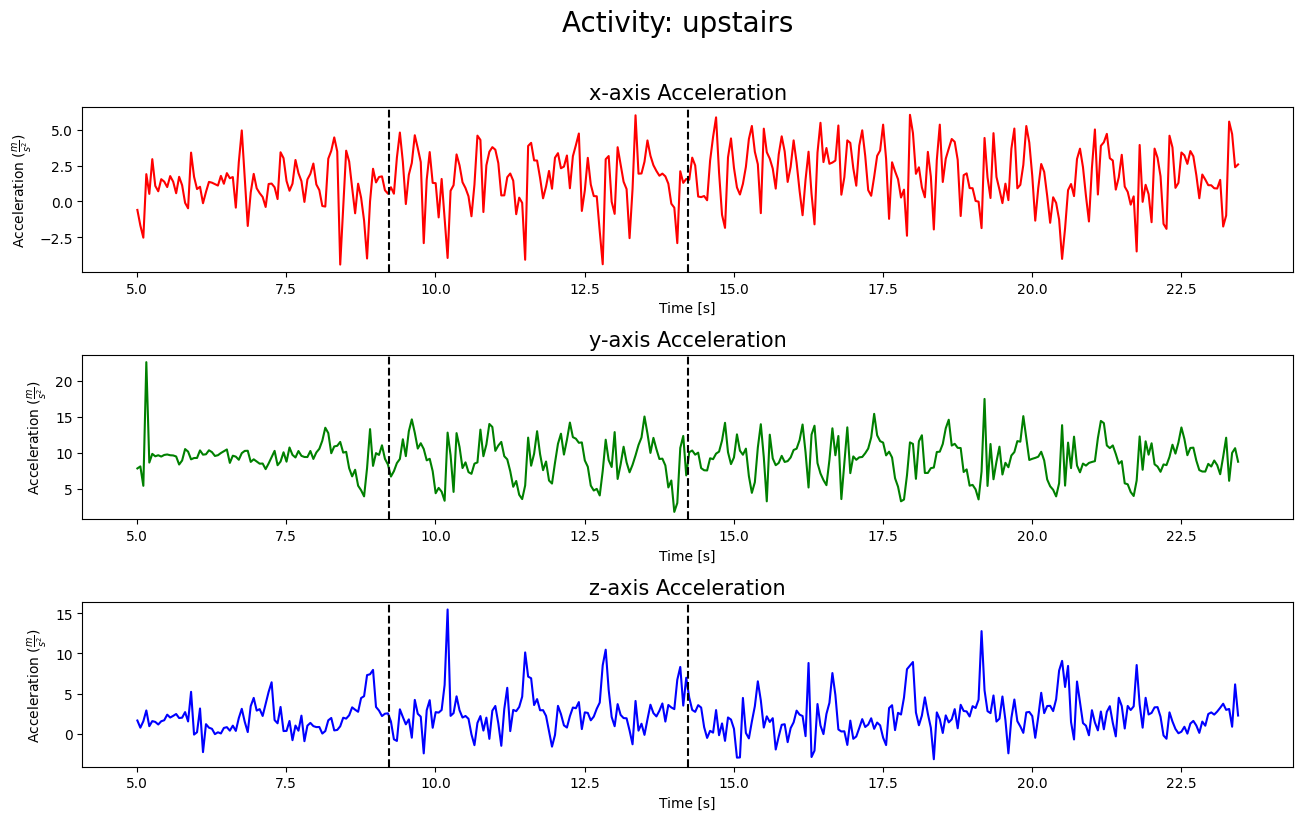

In [42]:
fig, ax = plt.subplots(3,1, figsize=(13,8))

label_fontsize = 10

ax[0].plot(clean_signal['time'], clean_signal['ax'], 'r')
ax[0].set_title("x-axis Acceleration", fontsize=label_fontsize+5)
ax[0].set_xlabel('Time [s]', fontsize=label_fontsize)
ax[0].set_ylabel('Acceleration ($\\frac{m}{s^2}$)', fontsize=label_fontsize)
ax[0].axvline(x=max(clean_signal['time'])/2 - signal_length/2, color='k', linestyle='--')
ax[0].axvline(x=max(clean_signal['time'])/2 + signal_length/2, color='k', linestyle='--')

ax[1].plot(clean_signal['time'], clean_signal['ay'], 'g')
ax[1].set_title("y-axis Acceleration", fontsize=label_fontsize+5)
ax[1].set_xlabel('Time [s]', fontsize=label_fontsize)
ax[1].set_ylabel('Acceleration ($\\frac{m}{s^2}$)', fontsize=label_fontsize)
ax[1].axvline(x=max(clean_signal['time'])/2 - signal_length/2, color='k', linestyle='--')
ax[1].axvline(x=max(clean_signal['time'])/2 + signal_length/2, color='k', linestyle='--')

ax[2].plot(clean_signal['time'], clean_signal['az'], 'b')
ax[2].set_title("z-axis Acceleration", fontsize=label_fontsize+5)
ax[2].set_xlabel('Time [s]', fontsize=label_fontsize)
ax[2].set_ylabel('Acceleration ($\\frac{m}{s^2}$)', fontsize=label_fontsize)
ax[2].axvline(x=max(clean_signal['time'])/2 - signal_length/2, color='k', linestyle='--')
ax[2].axvline(x=max(clean_signal['time'])/2 + signal_length/2, color='k', linestyle='--')

plt.suptitle(f'Activity: {activity}', fontsize= 20, x=0.515, y=1.02, ha='center')
plt.tight_layout()
plt.show()

Extracting the 5 seconds signal

In [43]:
axs = np.array(clean_signal['ax'][int(len(clean_signal)/2) - int(signal_length*sampling_rate/2) : int(len(clean_signal)/2) + int(signal_length*sampling_rate/2)])
ays = np.array(clean_signal['ay'][int(len(clean_signal)/2) - int(signal_length*sampling_rate/2) : int(len(clean_signal)/2) + int(signal_length*sampling_rate/2)])
azs = np.array(clean_signal['az'][int(len(clean_signal)/2) - int(signal_length*sampling_rate/2) : int(len(clean_signal)/2) + int(signal_length*sampling_rate/2)])

In [44]:
print(f"X_train shape: \t{axs.shape},\t\tmin value: {axs.min():.3f}, \tmax value: {axs.max():.3f}")
print(f"X_train shape: \t{ays.shape},\t\tmin value: {ays.min():.3f}, \tmax value: {ays.max():.3f}")
print(f"X_train shape: \t{azs.shape},\t\tmin value: {azs.min():.3f}, \tmax value: {azs.max():.3f}")

X_train shape: 	(100,),		min value: -4.401, 	max value: 6.024
X_train shape: 	(100,),		min value: 1.770, 	max value: 15.045
X_train shape: 	(100,),		min value: -2.954, 	max value: 10.472


Plotting the extracted segment of signal

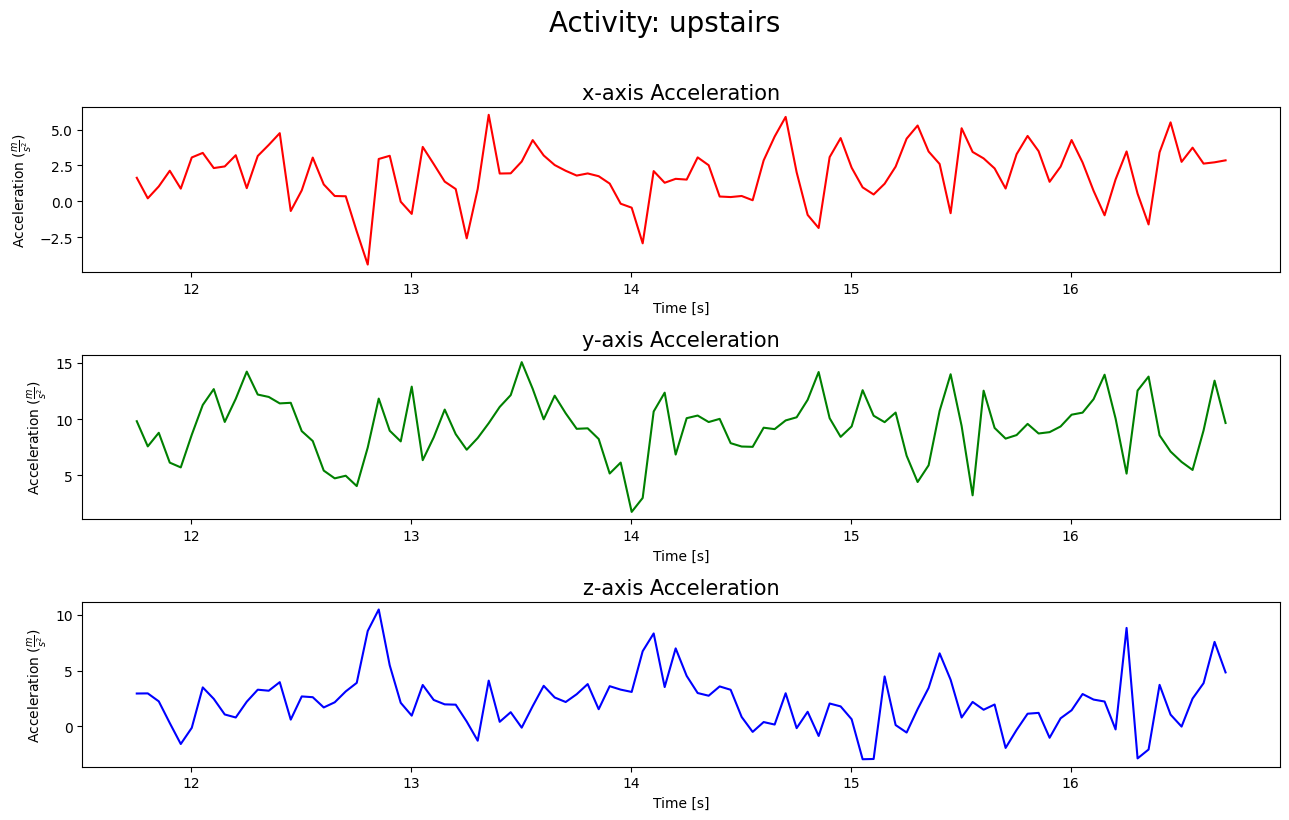

In [45]:
fig, ax = plt.subplots(3,1, figsize=(13,8))

label_fontsize = 10

ax[0].plot(clean_signal['time'][int(len(clean_signal)/2) - int(signal_length*sampling_rate/2) : int(len(clean_signal)/2) + int(signal_length*sampling_rate/2)], axs, 'r')
ax[0].set_title("x-axis Acceleration", fontsize=label_fontsize+5)
ax[0].set_xlabel('Time [s]', fontsize=label_fontsize)
ax[0].set_ylabel('Acceleration ($\\frac{m}{s^2}$)', fontsize=label_fontsize)

ax[1].plot(clean_signal['time'][int(len(clean_signal)/2) - int(signal_length*sampling_rate/2) : int(len(clean_signal)/2) + int(signal_length*sampling_rate/2)], ays, 'g')
ax[1].set_title("y-axis Acceleration", fontsize=label_fontsize+5)
ax[1].set_xlabel('Time [s]', fontsize=label_fontsize)
ax[1].set_ylabel('Acceleration ($\\frac{m}{s^2}$)', fontsize=label_fontsize)

ax[2].plot(clean_signal['time'][int(len(clean_signal)/2) - int(signal_length*sampling_rate/2) : int(len(clean_signal)/2) + int(signal_length*sampling_rate/2)], azs, 'b')
ax[2].set_title("z-axis Acceleration", fontsize=label_fontsize+5)
ax[2].set_xlabel('Time [s]', fontsize=label_fontsize)
ax[2].set_ylabel('Acceleration ($\\frac{m}{s^2}$)', fontsize=label_fontsize)

plt.suptitle(f'Activity: {activity}', fontsize= 20, x=0.515, y=1.02, ha='center')
plt.tight_layout()
plt.show()

Putting together the 3 axes

In [46]:
test_signal = []
labels = []

test_signal.append([axs, ays, azs])
labels.append(activity)
test_signal = np.asarray(test_signal)
labels = np.asarray(labels)

Loading the mean and the standard deviation of the training data and standardize the signal

In [47]:
os.makedirs(base_path + 'training_data/LSTM1/', exist_ok=True)

# Load the pickled data
with open(base_path + 'training_data/LSTM1/X_train_mean.pkl', 'rb') as f:
    X_train_mean = pickle.load(f)

with open(base_path + 'training_data/LSTM1/X_train_std.pkl', 'rb') as f:
    X_train_std = pickle.load(f)

In [48]:
test_signal[0] = (test_signal[0] - np.array(X_train_mean)[:, None]) / np.array(X_train_std)[:, None]

Transpose the signal on the second and last dimension to match the input shape of the model

In [49]:
test_signal = test_signal.transpose(0, 2, 1)
test_signal[0].shape

(100, 3)

In [50]:
test_signal.shape

(1, 100, 3)

Predict the activity

In [51]:
predicted_probabilities = LSTM1.predict(test_signal)

1/1 [==============================] - 1s 610ms/step


In [52]:
print(f"Ground Truth: {activity}\n\nLSTM1 Predictions:")
for i, act in enumerate(activities):
  print(f'{act}: {predicted_probabilities[0][i]*100:.2f}%')

Ground Truth: upstairs

LSTM1 Predictions:
walking: 0.65%
jogging: 0.13%
sitting: 0.01%
standing: 0.01%
upstairs: 99.01%
downstairs: 0.19%


In [53]:
predicted_activity_index = np.argmax(predicted_probabilities, axis=1)
predicted_activity = activities[predicted_activity_index[0]]
print(f'Ground Truth: {activity} \nPrediction: {predicted_activity}')

Ground Truth: upstairs 
Prediction: upstairs


# LSTM2

In [54]:
activities = ['walking', 'jogging', 'sitting', 'standing', 'upstairs', 'downstairs']

Loading the model

In [55]:
base_path = '/content/drive/MyDrive/DSaIM_project/1D/'

In [56]:
LSTM2_checkpoint_filepath = base_path + 'Models/LSTM2_checkpoint.keras'
LSTM2 = keras.models.load_model(LSTM2_checkpoint_filepath)

Taking a portion of the signal of length `signal_length = 5` seconds in the center of the signal

In [57]:
sampling_rate = 20
signal_length = 5

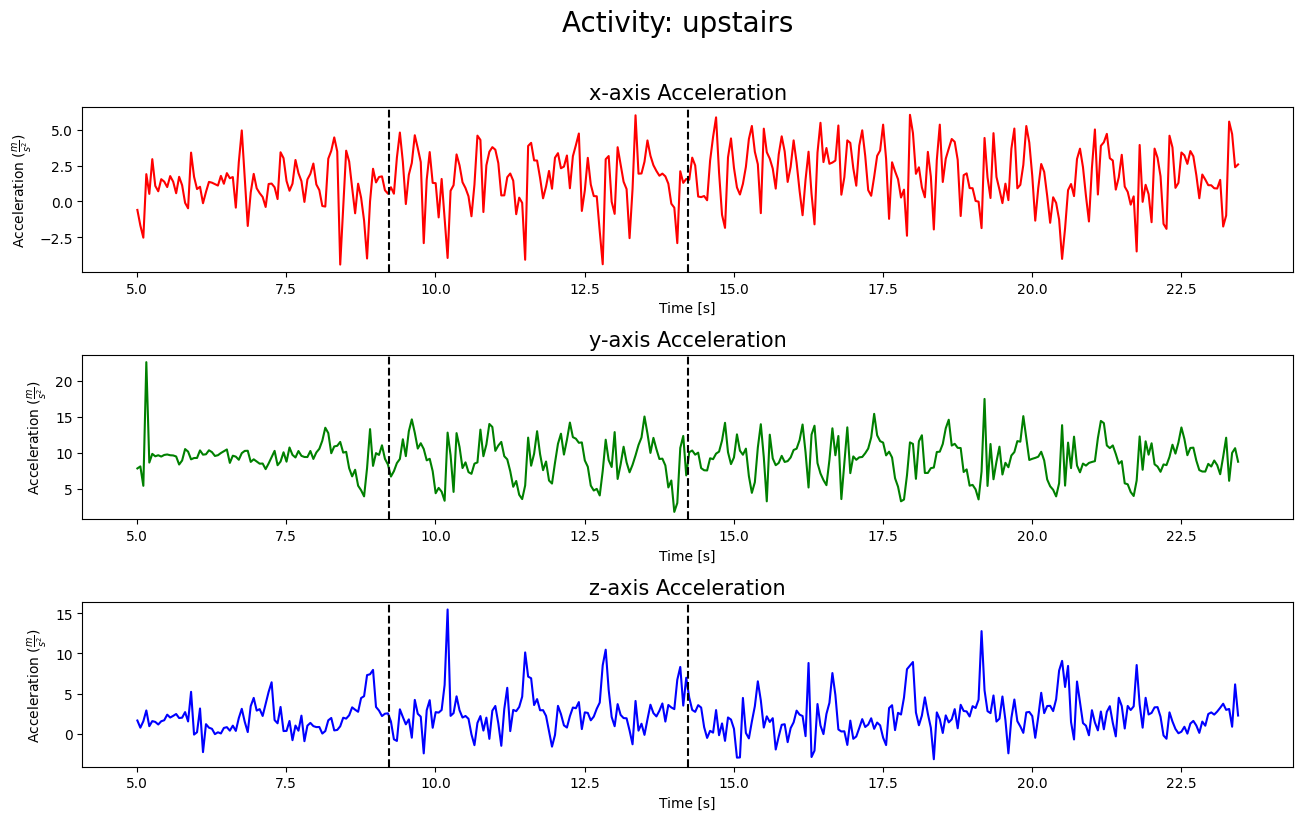

In [58]:
fig, ax = plt.subplots(3,1, figsize=(13,8))

label_fontsize = 10

ax[0].plot(clean_signal['time'], clean_signal['ax'], 'r')
ax[0].set_title("x-axis Acceleration", fontsize=label_fontsize+5)
ax[0].set_xlabel('Time [s]', fontsize=label_fontsize)
ax[0].set_ylabel('Acceleration ($\\frac{m}{s^2}$)', fontsize=label_fontsize)
ax[0].axvline(x=max(clean_signal['time'])/2 - signal_length/2, color='k', linestyle='--')
ax[0].axvline(x=max(clean_signal['time'])/2 + signal_length/2, color='k', linestyle='--')

ax[1].plot(clean_signal['time'], clean_signal['ay'], 'g')
ax[1].set_title("y-axis Acceleration", fontsize=label_fontsize+5)
ax[1].set_xlabel('Time [s]', fontsize=label_fontsize)
ax[1].set_ylabel('Acceleration ($\\frac{m}{s^2}$)', fontsize=label_fontsize)
ax[1].axvline(x=max(clean_signal['time'])/2 - signal_length/2, color='k', linestyle='--')
ax[1].axvline(x=max(clean_signal['time'])/2 + signal_length/2, color='k', linestyle='--')

ax[2].plot(clean_signal['time'], clean_signal['az'], 'b')
ax[2].set_title("z-axis Acceleration", fontsize=label_fontsize+5)
ax[2].set_xlabel('Time [s]', fontsize=label_fontsize)
ax[2].set_ylabel('Acceleration ($\\frac{m}{s^2}$)', fontsize=label_fontsize)
ax[2].axvline(x=max(clean_signal['time'])/2 - signal_length/2, color='k', linestyle='--')
ax[2].axvline(x=max(clean_signal['time'])/2 + signal_length/2, color='k', linestyle='--')

plt.suptitle(f'Activity: {activity}', fontsize= 20, x=0.515, y=1.02, ha='center')
plt.tight_layout()
plt.show()

In [59]:
axs = np.array(clean_signal['ax'][int(len(clean_signal)/2) - int(signal_length*sampling_rate/2) : int(len(clean_signal)/2) + int(signal_length*sampling_rate/2)])
ays = np.array(clean_signal['ay'][int(len(clean_signal)/2) - int(signal_length*sampling_rate/2) : int(len(clean_signal)/2) + int(signal_length*sampling_rate/2)])
azs = np.array(clean_signal['az'][int(len(clean_signal)/2) - int(signal_length*sampling_rate/2) : int(len(clean_signal)/2) + int(signal_length*sampling_rate/2)])

In [60]:
print(f"X_train shape: \t{axs.shape},\t\tmin value: {axs.min():.3f}, \tmax value: {axs.max():.3f}")
print(f"X_train shape: \t{ays.shape},\t\tmin value: {ays.min():.3f}, \tmax value: {ays.max():.3f}")
print(f"X_train shape: \t{azs.shape},\t\tmin value: {azs.min():.3f}, \tmax value: {azs.max():.3f}")

X_train shape: 	(100,),		min value: -4.401, 	max value: 6.024
X_train shape: 	(100,),		min value: 1.770, 	max value: 15.045
X_train shape: 	(100,),		min value: -2.954, 	max value: 10.472


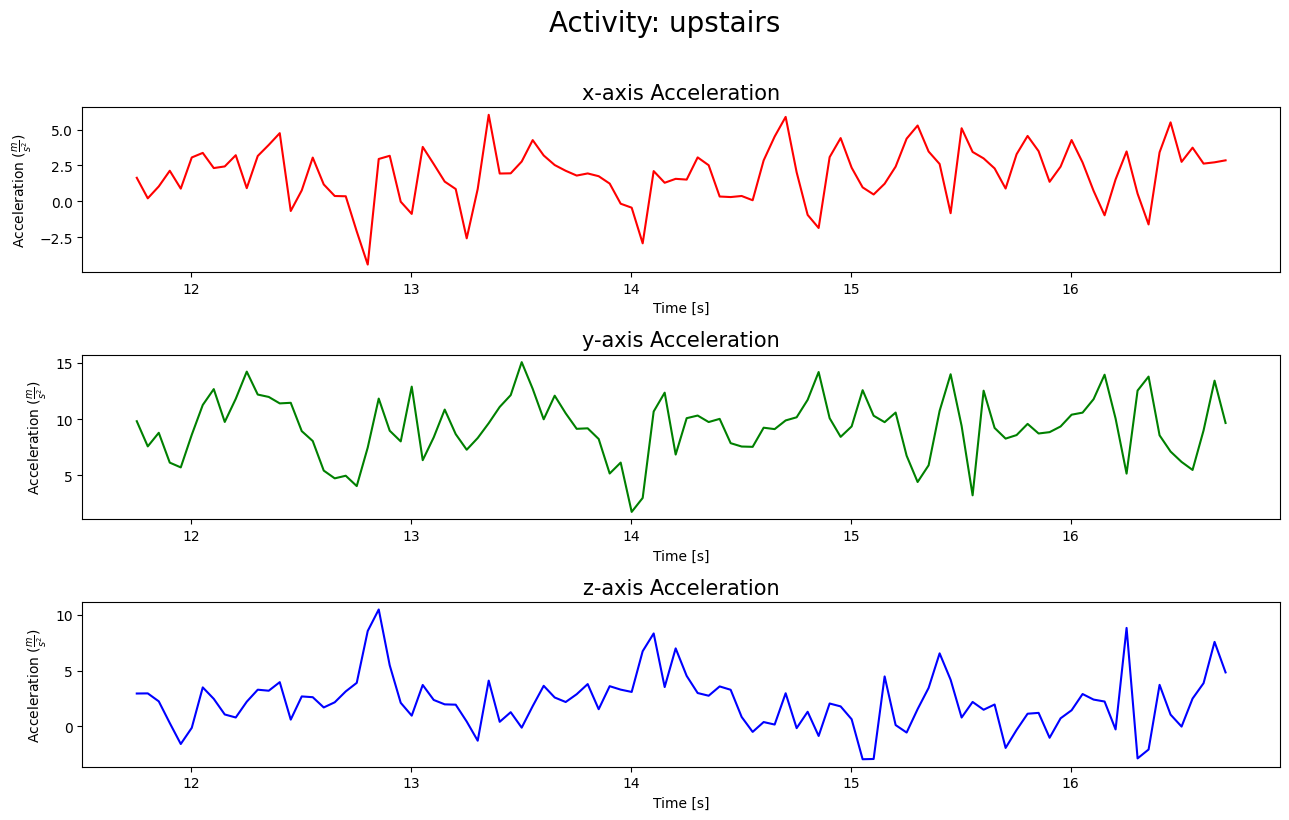

In [61]:
fig, ax = plt.subplots(3,1, figsize=(13,8))

label_fontsize = 10

ax[0].plot(clean_signal['time'][int(len(clean_signal)/2) - int(signal_length*sampling_rate/2) : int(len(clean_signal)/2) + int(signal_length*sampling_rate/2)], axs, 'r')
ax[0].set_title("x-axis Acceleration", fontsize=label_fontsize+5)
ax[0].set_xlabel('Time [s]', fontsize=label_fontsize)
ax[0].set_ylabel('Acceleration ($\\frac{m}{s^2}$)', fontsize=label_fontsize)

ax[1].plot(clean_signal['time'][int(len(clean_signal)/2) - int(signal_length*sampling_rate/2) : int(len(clean_signal)/2) + int(signal_length*sampling_rate/2)], ays, 'g')
ax[1].set_title("y-axis Acceleration", fontsize=label_fontsize+5)
ax[1].set_xlabel('Time [s]', fontsize=label_fontsize)
ax[1].set_ylabel('Acceleration ($\\frac{m}{s^2}$)', fontsize=label_fontsize)

ax[2].plot(clean_signal['time'][int(len(clean_signal)/2) - int(signal_length*sampling_rate/2) : int(len(clean_signal)/2) + int(signal_length*sampling_rate/2)], azs, 'b')
ax[2].set_title("z-axis Acceleration", fontsize=label_fontsize+5)
ax[2].set_xlabel('Time [s]', fontsize=label_fontsize)
ax[2].set_ylabel('Acceleration ($\\frac{m}{s^2}$)', fontsize=label_fontsize)

plt.suptitle(f'Activity: {activity}', fontsize= 20, x=0.515, y=1.02, ha='center')
plt.tight_layout()
plt.show()

Putting together the 3 axes

In [62]:
test_signal = []
labels = []

test_signal.append([axs, ays, azs])
labels.append(activity)
test_signal = np.asarray(test_signal)
labels = np.asarray(labels)

Loading the mean and the standard deviation of the training data and standardize the signal

In [63]:
os.makedirs(base_path + 'training_data/LSTM1/', exist_ok=True)

# Load the pickled data
with open(base_path + 'training_data/LSTM1/X_train_mean.pkl', 'rb') as f:
    X_train_mean = pickle.load(f)

with open(base_path + 'training_data/LSTM1/X_train_std.pkl', 'rb') as f:
    X_train_std = pickle.load(f)

In [64]:
test_signal[0] = (test_signal[0] - np.array(X_train_mean)[:, None]) / np.array(X_train_std)[:, None]

Transpose the signal on the second and last dimension to match the input shape of the model

In [65]:
test_signal.shape

(1, 3, 100)

In [66]:
test_signal = test_signal.transpose(0, 2, 1)
test_signal[0].shape

(100, 3)

In [67]:
test_signal.shape

(1, 100, 3)

Predict the activity

In [68]:
predicted_probabilities = LSTM2.predict(test_signal)

1/1 [==============================] - 2s 2s/step


In [69]:
print(f"Ground Truth: {activity}\n\nLSTM2 Predictions:")
for i, act in enumerate(activities):
  print(f'{act}: {predicted_probabilities[0][i]*100:.2f}%')

Ground Truth: upstairs

LSTM2 Predictions:
walking: 0.01%
jogging: 0.01%
sitting: 0.01%
standing: 0.00%
upstairs: 99.12%
downstairs: 0.85%


In [70]:
predicted_activity_index = np.argmax(predicted_probabilities, axis=1)
predicted_activity = activities[predicted_activity_index[0]]
print(f'Ground Truth: {activity} \nPrediction: {predicted_activity}')

Ground Truth: upstairs 
Prediction: upstairs


# LSTM3

In [71]:
activities = ['walking', 'jogging', 'sitting', 'standing', 'upstairs', 'downstairs']

Loading the model

In [72]:
base_path = '/content/drive/MyDrive/DSaIM_project/1D/'

In [73]:
LSTM3_checkpoint_filepath = base_path + 'Models/LSTM3_checkpoint.keras'
LSTM3 = keras.models.load_model(LSTM3_checkpoint_filepath)

Taking a portion of the signal of length `signal_length = 5` seconds in the center of the signal

In [74]:
sampling_rate = 20
signal_length = 5

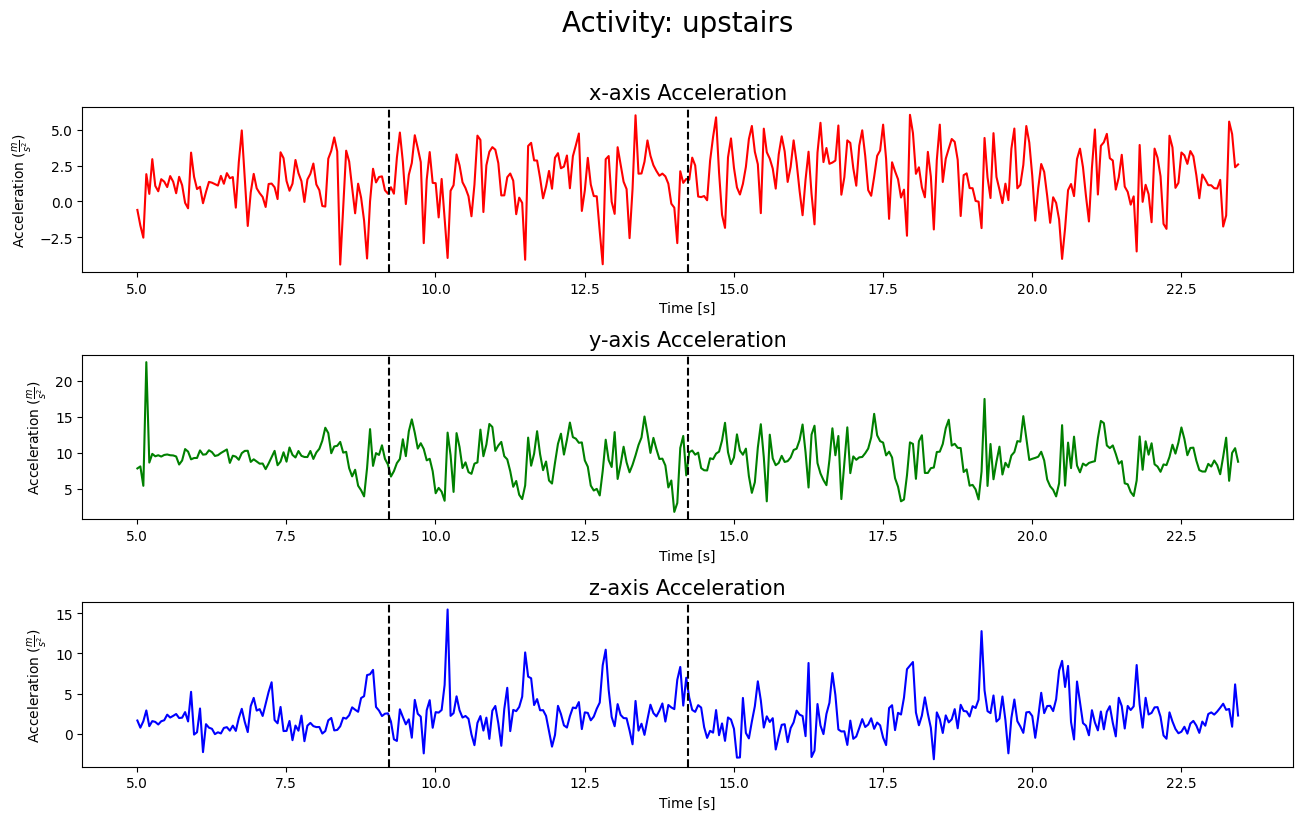

In [75]:
fig, ax = plt.subplots(3,1, figsize=(13,8))

label_fontsize = 10

ax[0].plot(clean_signal['time'], clean_signal['ax'], 'r')
ax[0].set_title("x-axis Acceleration", fontsize=label_fontsize+5)
ax[0].set_xlabel('Time [s]', fontsize=label_fontsize)
ax[0].set_ylabel('Acceleration ($\\frac{m}{s^2}$)', fontsize=label_fontsize)
ax[0].axvline(x=max(clean_signal['time'])/2 - signal_length/2, color='k', linestyle='--')
ax[0].axvline(x=max(clean_signal['time'])/2 + signal_length/2, color='k', linestyle='--')

ax[1].plot(clean_signal['time'], clean_signal['ay'], 'g')
ax[1].set_title("y-axis Acceleration", fontsize=label_fontsize+5)
ax[1].set_xlabel('Time [s]', fontsize=label_fontsize)
ax[1].set_ylabel('Acceleration ($\\frac{m}{s^2}$)', fontsize=label_fontsize)
ax[1].axvline(x=max(clean_signal['time'])/2 - signal_length/2, color='k', linestyle='--')
ax[1].axvline(x=max(clean_signal['time'])/2 + signal_length/2, color='k', linestyle='--')

ax[2].plot(clean_signal['time'], clean_signal['az'], 'b')
ax[2].set_title("z-axis Acceleration", fontsize=label_fontsize+5)
ax[2].set_xlabel('Time [s]', fontsize=label_fontsize)
ax[2].set_ylabel('Acceleration ($\\frac{m}{s^2}$)', fontsize=label_fontsize)
ax[2].axvline(x=max(clean_signal['time'])/2 - signal_length/2, color='k', linestyle='--')
ax[2].axvline(x=max(clean_signal['time'])/2 + signal_length/2, color='k', linestyle='--')

plt.suptitle(f'Activity: {activity}', fontsize= 20, x=0.515, y=1.02, ha='center')
plt.tight_layout()
plt.show()

In [76]:
axs = np.array(clean_signal['ax'][int(len(clean_signal)/2) - int(signal_length*sampling_rate/2) : int(len(clean_signal)/2) + int(signal_length*sampling_rate/2)])
ays = np.array(clean_signal['ay'][int(len(clean_signal)/2) - int(signal_length*sampling_rate/2) : int(len(clean_signal)/2) + int(signal_length*sampling_rate/2)])
azs = np.array(clean_signal['az'][int(len(clean_signal)/2) - int(signal_length*sampling_rate/2) : int(len(clean_signal)/2) + int(signal_length*sampling_rate/2)])

In [77]:
print(f"X_train shape: \t{axs.shape},\t\tmin value: {axs.min():.3f}, \tmax value: {axs.max():.3f}")
print(f"X_train shape: \t{ays.shape},\t\tmin value: {ays.min():.3f}, \tmax value: {ays.max():.3f}")
print(f"X_train shape: \t{azs.shape},\t\tmin value: {azs.min():.3f}, \tmax value: {azs.max():.3f}")

X_train shape: 	(100,),		min value: -4.401, 	max value: 6.024
X_train shape: 	(100,),		min value: 1.770, 	max value: 15.045
X_train shape: 	(100,),		min value: -2.954, 	max value: 10.472


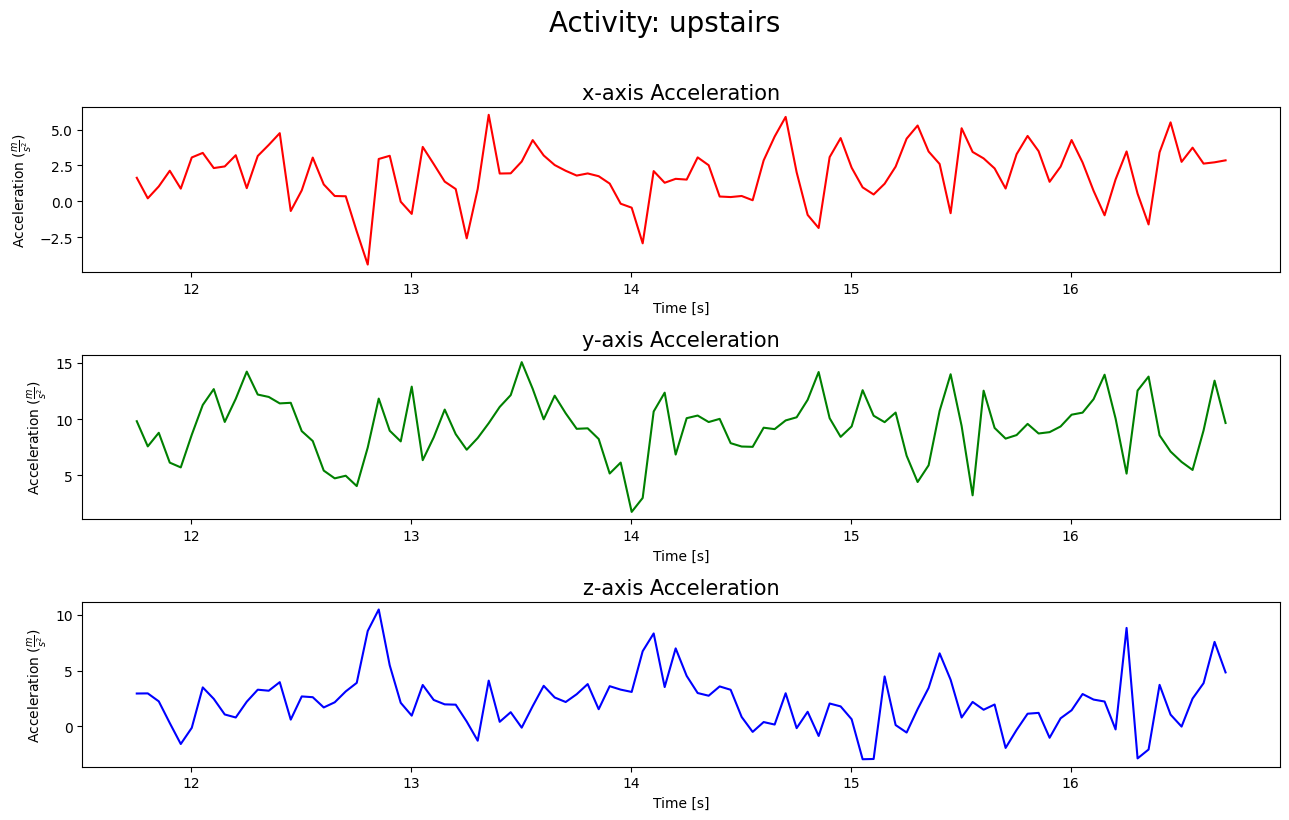

In [78]:
fig, ax = plt.subplots(3,1, figsize=(13,8))

label_fontsize = 10

ax[0].plot(clean_signal['time'][int(len(clean_signal)/2) - int(signal_length*sampling_rate/2) : int(len(clean_signal)/2) + int(signal_length*sampling_rate/2)], axs, 'r')
ax[0].set_title("x-axis Acceleration", fontsize=label_fontsize+5)
ax[0].set_xlabel('Time [s]', fontsize=label_fontsize)
ax[0].set_ylabel('Acceleration ($\\frac{m}{s^2}$)', fontsize=label_fontsize)

ax[1].plot(clean_signal['time'][int(len(clean_signal)/2) - int(signal_length*sampling_rate/2) : int(len(clean_signal)/2) + int(signal_length*sampling_rate/2)], ays, 'g')
ax[1].set_title("y-axis Acceleration", fontsize=label_fontsize+5)
ax[1].set_xlabel('Time [s]', fontsize=label_fontsize)
ax[1].set_ylabel('Acceleration ($\\frac{m}{s^2}$)', fontsize=label_fontsize)

ax[2].plot(clean_signal['time'][int(len(clean_signal)/2) - int(signal_length*sampling_rate/2) : int(len(clean_signal)/2) + int(signal_length*sampling_rate/2)], azs, 'b')
ax[2].set_title("z-axis Acceleration", fontsize=label_fontsize+5)
ax[2].set_xlabel('Time [s]', fontsize=label_fontsize)
ax[2].set_ylabel('Acceleration ($\\frac{m}{s^2}$)', fontsize=label_fontsize)

plt.suptitle(f'Activity: {activity}', fontsize= 20, x=0.515, y=1.02, ha='center')
plt.tight_layout()
plt.show()

Putting together the 3 axes

In [79]:
test_signal = []
labels = []

test_signal.append([axs, ays, azs])
labels.append(activity)
test_signal = np.asarray(test_signal)
labels = np.asarray(labels)

Loading the mean and the standard deviation of the training data and standardize the signal

In [80]:
os.makedirs(base_path + 'training_data/LSTM1/', exist_ok=True)

# Load the pickled data
with open(base_path + 'training_data/LSTM1/X_train_mean.pkl', 'rb') as f:
    X_train_mean = pickle.load(f)

with open(base_path + 'training_data/LSTM1/X_train_std.pkl', 'rb') as f:
    X_train_std = pickle.load(f)

In [81]:
test_signal[0] = (test_signal[0] - np.array(X_train_mean)[:, None]) / np.array(X_train_std)[:, None]

Transpose the signal on the second and last dimension to match the input shape of the model

In [82]:
test_signal.shape

(1, 3, 100)

In [83]:
test_signal = test_signal.transpose(0, 2, 1)
test_signal[0].shape

(100, 3)

In [84]:
test_signal.shape

(1, 100, 3)

Predict the activity

In [85]:
predicted_probabilities = LSTM3.predict(test_signal)

1/1 [==============================] - 1s 1s/step


In [86]:
print(f"Ground Truth: {activity}\n\nLSTM3 Predictions:")
for i, act in enumerate(activities):
  print(f'{act}: {predicted_probabilities[0][i]*100:.2f}%')

Ground Truth: upstairs

LSTM3 Predictions:
walking: 0.00%
jogging: 0.00%
sitting: 0.00%
standing: 0.00%
upstairs: 100.00%
downstairs: 0.00%


In [87]:
predicted_activity_index = np.argmax(predicted_probabilities, axis=1)
predicted_activity = activities[predicted_activity_index[0]]
print(f'Ground Truth: {activity} \nPrediction: {predicted_activity}')

Ground Truth: upstairs 
Prediction: upstairs
